# Setting environment

In [0]:
_=[i for i in range(999999999)]

Run the above cell to get more ram by making session crashed.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mount google drive by excuting the above cell

In [0]:
import tensorflow as tf
print(tf.__version__, tf.__file__)
import keras
print(keras.__version__, keras.__file__)

2.2.0-rc4 /usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py
2.3.1 /usr/local/lib/python3.6/dist-packages/keras/__init__.py


Using TensorFlow backend.


# Import package

In [0]:
#from keras.preprocessing.image import ImageDataGenerator
#不使用 keras 的圖片資料讀取功能，因為雲端環境不適合使用 generator  

In [0]:
import numpy as np
import os

# Loading images

In [45]:
import importlib

u = importlib.import_module("drive.Shared drives.深度學習於生醫資料分析.util")
#使用汪汪的工具模組，使用方法請用 help() 指令來查詢

help(u)

Help on module drive.Shared drives.深度學習於生醫資料分析.util in drive.Shared drives.深度學習於生醫資料分析:

NAME
    drive.Shared drives.深度學習於生醫資料分析.util

CLASSES
    builtins.object
        Img_reader
    
    class Img_reader(builtins.object)
     |  能以多線程的方式讀取圖片資料，將其依據資料夾自動分類，並處理成 array 和標籤
     |  
     |  Parameters:
     |      path:       圖片資料的路徑。
     |  
     |      label_name: 標籤名稱的 list，需能對應上路徑中的各類別資料夾名稱，若不指定，會自行判斷。
     |  
     |      size:       訓練資料的 array size，需包含色彩軸，若圖片為灰階，色彩軸應為 1。
     |  
     |      rescale:    圖片重訂比例。
     |  
     |  Return:
     |      圖片讀取的物件
     |  
     |  Methods defined here:
     |  
     |  __init__(self, path, label_name=None, size=(512, 512, 1), rescale=None)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  read_by_thread(self, thread_num=3, shuffle=True)
     |      開始讀圖片資料。
     |      
     |      Parameters:
     |          thread_num: 多線程數量。
     |      
     |          shuffle:    是否將資料順序打亂。
     |         

In [0]:
Img_reader = u.Img_reader   #圖片資料讀取物件
vis_img = u.vis_img   #顯示圖片 array 

In [47]:
#先建立訓練資料用的圖片資料讀取物件

train_reader = Img_reader("/content/drive/Shared drives/深度學習於生醫資料分析/MURA/train/", # 訓練集圖片的文件夾
                          size = (224,224,1), # 調整後每張圖片的大小
                          rescale = 1/255.) # 圖片像素值為0-255，此處都乘以1/255，調整到0-1之間

label_name = train_reader.label_name
print(train_reader.label_name) #訓練資料的標籤名 list


['WRIST_negative', 'ELBOW_negative', 'SHOULDER_negative']


> 以上 rescale 的技巧稱為資料正規化(normalization)，此操作是為了讓輸入資料和 weights 有相似的 range，以避免需花費額化的時間成本在調整超參數上(例如 learning rate)。



In [0]:
#np.random.seed(5)
train_data,train_label = train_reader.read_by_thread(thread_num = 1000,  #指定要使用多少線程
                                                    shuffle = True)  #是否打亂資料集順序

Found 9032 images belonging to 3 classes.
100%




> 以上方法與 keras 的 flow_from_directory() 不同之處在於，這是直接將資料讀進系統的 ram 中，而 keras 是以 generator 的形式產生資料，所以每次皆會重新讀取，能省去大量記憶體空間。然而對雲端環境來說，每次讀檔就要下載一次資料，因此不適合。



In [0]:
train_data.shape

(9032, 224, 224, 1)

In [0]:
# train_datagen = ImageDataGenerator(rescale=1. / 255) # 圖片像素值為0-255，此處都乘以1/255，調整到0-1之間
# train_generator = train_datagen.flow_from_directory( # 從文件夾中產生數據流
#     directory="/content/drive/Shared drives/深度學習於生醫資料分析/MURA/train/", # 訓練集圖片的文件夾
#     target_size=(224, 224), # 調整後每張圖片的大小
#     batch_size=32,
# )

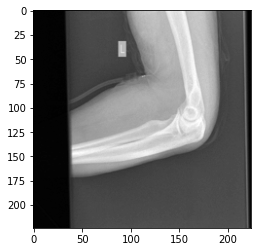

In [0]:
vis_img(train_data[0])

In [0]:
vali_reader = Img_reader("/content/drive/Shared drives/深度學習於生醫資料分析/MURA/valid/", # 訓練集圖片的文件夾
                         label_name = label_name,
                         size = (224,224,1), # 調整後每張圖片的大小
                         rescale = 1/255.) # 圖片像素值為0-255，此處都乘以1/255，調整到0-1之間

vali_data,vali_label = vali_reader.read_by_thread(thread_num = 1000,  #指定要使用多少線程
                                                  shuffle = True)  #是否打亂資料集順序

Found 1289 images belonging to 3 classes.
100%


In [51]:
test_reader = Img_reader("/content/drive/Shared drives/深度學習於生醫資料分析/MURA/test/", # 訓練集圖片的文件夾
                         label_name = label_name,
                         size = (224,224,1), # 調整後每張圖片的大小
                         rescale = 1/255.) # 圖片像素值為0-255，此處都乘以1/255，調整到0-1之間

test_data,test_label = test_reader.read_by_thread(thread_num = 1000,  #指定要使用多少線程
                                                  shuffle = True)  #是否打亂資料集順序

Found 2580 images belonging to 3 classes.
100%


# Model building

以下改用 tf.keras，因為 colab 上的 keras 和 tensorflow 版本不相容

In [0]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow.keras.models import load_model

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [0]:
#@title Define VGG16 creating function
def VGG16():
    img_input = Input(shape=(224,224,1))
    
    x = Conv2D(filters=64, kernel_size=(3,3),
               activation='relu', padding='same')(img_input)
    x = Conv2D(filters=64, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2, 2))(x)
    
    x = Conv2D(filters=128, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2, 2))(x)
    
    x = Conv2D(filters=256, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = Conv2D(filters=256, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = Conv2D(filters=256, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2, 2))(x)
    
    x = Conv2D(filters=512, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2, 2))(x)
    
    x = Conv2D(filters=512, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3,3),
               activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2, 2))(x)
    
    x = Flatten()(x)
    
    x = Dense(4096, activation='relu')(x)
    
    x = Dense(3, activation='softmax')(x)
    
    return Model(inputs=img_input, outputs=x)
    

In [52]:
model_folder = "/content/drive/My Drive/YM_HW_VGG16_model"

if not os.path.exists(model_folder):
    os.mkdir(model_folder)
    print("建立資料夾: " + model_folder)
else:
    print(model_folder + " 資料夾已存在")

model_path = "/content/drive/My Drive/YM_HW_VGG16_model/weights.h5"
if os.path.exists(model_path):
    print("Found model, it will keep training!")
    model = load_model(model_path)
else:
    model = VGG16()

/content/drive/My Drive/YM_HW_VGG16_model 資料夾已存在


In [53]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0   

# Compile the model

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
model.compile(loss='sparse_categorical_crossentropy', #因標籤為整數資料，故使用此損失函數
              optimizer=Adam(lr=0.0001),  #lr:學習率 = 0.0001
              metrics=['accuracy'])

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

#filepath="/content/drive/My Drive/YM/HW_VGG16/model/weights-{epoch:02d}-{val_acc:.2f}.h5"
filepath="/content/drive/My Drive/YM_HW_VGG16_model/weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#只存取準確率最高的模型和權重
callbacks_list = [checkpoint]

# Start training

In [0]:
# train_history = model.fit_generator(train_generator, 
#                                     epochs=10, verbose=1, #verbose:詳細信息模式，0或者1
#                                     #callbacks=callbacks_list,
#                                     validation_data=valid_generator)

建議不論 generator 還是資料集都使用 fit()

In [0]:
train_history = model.fit(train_data,train_label,
                          epochs=10,
                          verbose=1, #verbose:詳細信息模式，0或者1
                          callbacks=callbacks_list,
                          validation_data=(vali_data,vali_label),
                          batch_size=32,
                          )

Epoch 1/10
283/283 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9946
Epoch 00001: val_accuracy did not improve from 0.97905
283/283 [==============================] - 240s 846ms/step - loss: 0.0221 - accuracy: 0.9946 - val_loss: 0.0783 - val_accuracy: 0.9760
Epoch 2/10
283/283 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9984
Epoch 00002: val_accuracy did not improve from 0.97905
283/283 [==============================] - 240s 847ms/step - loss: 0.0032 - accuracy: 0.9984 - val_loss: 0.1135 - val_accuracy: 0.9736
Epoch 3/10
283/283 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9951
Epoch 00003: val_accuracy did not improve from 0.97905
283/283 [==============================] - 240s 847ms/step - loss: 0.0129 - accuracy: 0.9951 - val_loss: 0.1739 - val_accuracy: 0.9643
Epoch 4/10
283/283 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9966
Epoch 00004: val_accuracy did not improve from

# Save model

In [0]:
#model.save("/content/drive/My Drive/Colab Notebooks/VGG16_224_Model_MURA.h5")

# Draw the training processing plot

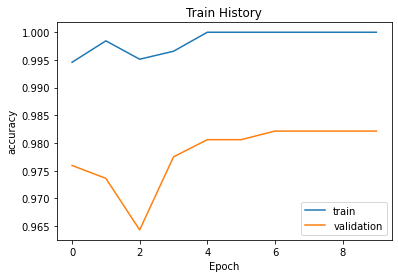

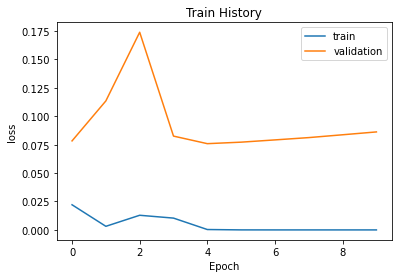

In [0]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.savefig('Train_History_accuracy.png')

plt.figure(1)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Train History')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('Train_History_loss.png')

plt.show()

建議都改用 evaluate()

In [0]:
# scores = model.evaluate_generator(generator=train_generator)
# scores[1]

In [0]:
scores = model.evaluate(train_data,train_label)
print("train_acc:",scores[1])

283/283 [==============================] - 76s 269ms/step - loss: 1.5337e-06 - accuracy: 1.0000
train_acc: 1.0


In [0]:
vali_scores = model.evaluate(vali_data,vali_label)
print("valid_acc:",vali_scores[1])

41/41 [==============================] - 11s 258ms/step - loss: 0.0862 - accuracy: 0.9822
valid_acc: 0.9821566939353943


# Testing

In [0]:
test_scores = model.evaluate(test_data,test_label)
print("test_acc:",test_scores[1])

81/81 [==============================] - 7s 81ms/step - loss: 1.0987 - accuracy: 0.2248
test_acc: 0.22480620443820953


In [0]:
pred=model.predict(test_data)

In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

# Confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
CNN_confusion_matrix=confusion_matrix(test_label, predicted_class_indices)
CNN_confusion_matrix

array([[1124,   23,    6],
       [  15,  563,    7],
       [   2,   15,  825]])

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(test_label, predicted_class_indices, normalize=True, sample_weight=None)

0.9736434108527132

# Visualization

In [0]:
model.layers[-2].output

<tf.Tensor 'dense/Identity:0' shape=(None, 4096) dtype=float32>

In [0]:
a = Model(inputs = model.input, outputs=model.layers[-2].output)

In [0]:
a.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0   

In [0]:
pred = a.predict(test_data)

In [0]:
pred.shape

(2580, 4096)

In [0]:
pred[0]

array([0.        , 0.        , 0.00043901, ..., 0.00017122, 0.00029233,
       0.00067869], dtype=float32)

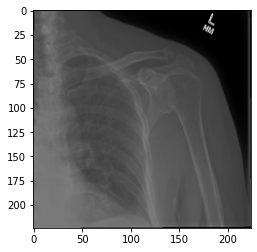

In [0]:
vis_img(test_data[5])

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(pred)
pred_new = pca.transform(pred)

In [0]:
pred_new[0]

array([-0.0008676, -0.003531 ], dtype=float32)

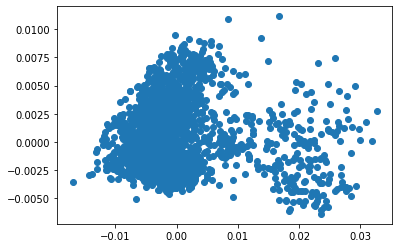

In [0]:
import matplotlib.pyplot as plt

plt.scatter(pred_new[:,0],pred_new[:,1])
plt.show()

In [0]:
test_label[5]

2.0

In [0]:
label_name

['WRIST_negative', 'ELBOW_negative', 'SHOULDER_negative']

In [0]:
data1=pred_new[np.where(test_label==0)]
data2=pred_new[np.where(test_label==1)]
data3=pred_new[np.where(test_label==2)]

In [0]:
test_label[:10]

array([2., 2., 0., 2., 2., 2., 1., 1., 0., 2.])

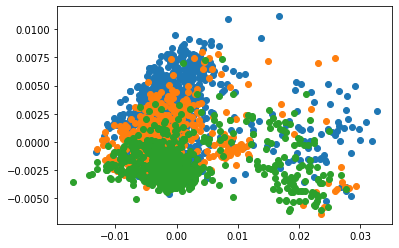

In [0]:
import matplotlib.pyplot as plt

plt.scatter(data1[:,0],data1[:,1])
plt.scatter(data2[:,0],data2[:,1])
plt.scatter(data3[:,0],data3[:,1])
plt.show()